# Deliverable 7.1: Nonlinear MPC for Landing

Implement and test a nonlinear MPC controller using CasADi for the full 12-state rocket system.

In [4]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from src.rocket import Rocket
from src.pos_rocket_vis import *
from LandMPC.nmpc_land import NmpcCtrl
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!
rocket.controller_type = 'NmpcCtrl'  # IMPORTANT: Set for proper NMPC constraint checking

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [ ]:
# Landing maneuver: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
sim_time = 15  # simulation length in seconds

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Target state: (1, 0, 3, 0°)
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3

xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

# NMPC parameters
H = 3.0  # horizon time

# Create nonlinear MPC controller
nmpc = NmpcCtrl(rocket, Ts=Ts, H=H)
print("\nNonlinear MPC initialized")
print(f"  - Horizon: {nmpc.N} steps ({H}s)")
print(f"  - State dimension: {nmpc.nx}")
print(f"  - Input dimension: {nmpc.nu}")
print(f"  - Uses full nonlinear dynamics (no subsystem decomposition)")

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

Nonlinear MPC initialized
  - Horizon: 40 steps (2.0s)
  - State dimension: 12
  - Input dimension: 4
  - Uses full nonlinear dynamics (no subsystem decomposition)


## Test 1: Check Open-Loop Trajectory

Before running closed-loop, verify that the optimal open-loop trajectory from the initial state is reasonable.

Open-loop trajectory computed:
  - Initial control: [-0.2617994   0.2617994  23.56123095 -2.97785859]
  - Final state: [ 0.06509588 -0.1046768  -0.05280917 -0.07098029  0.07649654 -0.02765435
 -0.9516405  -0.65227593 -4.76881253  0.8660397  -0.20032994  2.39822389]
  - Target state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]


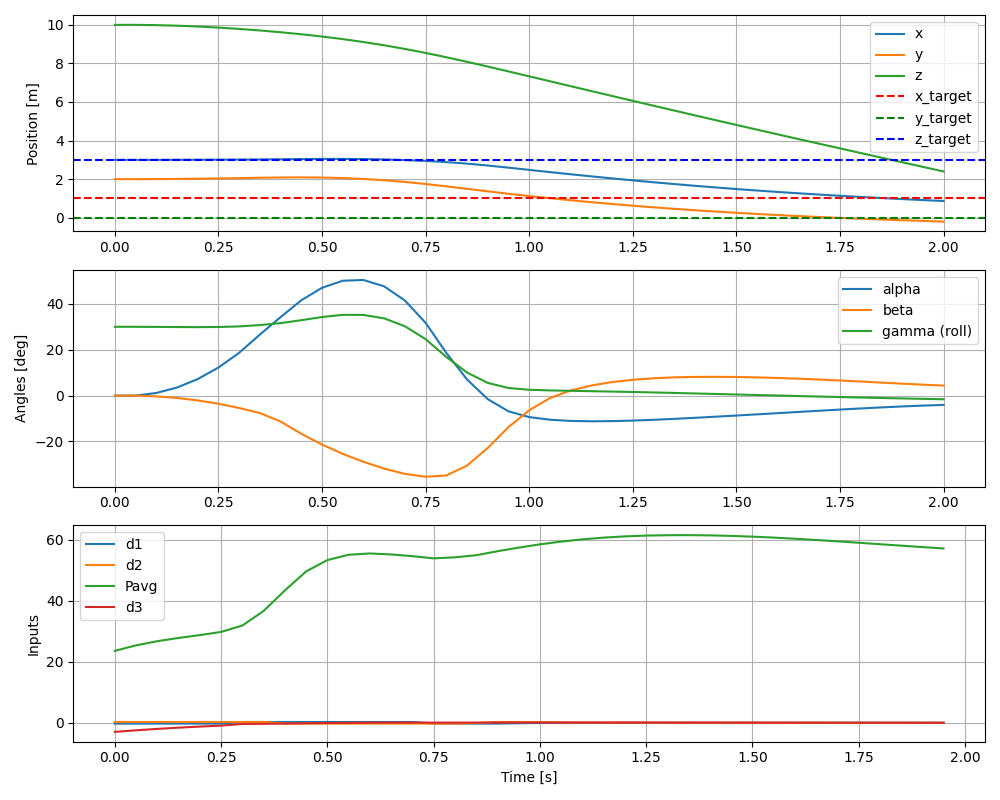

In [7]:
# Compute open-loop optimal trajectory
u0, x_ol, u_ol, t_ol = nmpc.get_u(0.0, x0, xs, us)

print("Open-loop trajectory computed:")
print(f"  - Initial control: {u0}")
print(f"  - Final state: {x_ol[:, -1]}")
print(f"  - Target state: {xs}")

# Plot open-loop trajectory
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Positions
axs[0].plot(t_ol, x_ol[9, :], label='x')
axs[0].plot(t_ol, x_ol[10, :], label='y')
axs[0].plot(t_ol, x_ol[11, :], label='z')
axs[0].axhline(y=xs[9], color='r', linestyle='--', label='x_target')
axs[0].axhline(y=xs[10], color='g', linestyle='--', label='y_target')
axs[0].axhline(y=xs[11], color='b', linestyle='--', label='z_target')
axs[0].set_ylabel('Position [m]')
axs[0].legend()
axs[0].grid(True)

# Angles
axs[1].plot(t_ol, np.rad2deg(x_ol[3, :]), label='alpha')
axs[1].plot(t_ol, np.rad2deg(x_ol[4, :]), label='beta')
axs[1].plot(t_ol, np.rad2deg(x_ol[5, :]), label='gamma (roll)')
axs[1].set_ylabel('Angles [deg]')
axs[1].legend()
axs[1].grid(True)

# Inputs
axs[2].plot(t_ol[:-1], u_ol[0, :], label='d1')
axs[2].plot(t_ol[:-1], u_ol[1, :], label='d2')
axs[2].plot(t_ol[:-1], u_ol[2, :], label='Pavg')
axs[2].plot(t_ol[:-1], u_ol[3, :], label='d3')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Inputs')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Test 2: Closed-Loop Simulation

In [8]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(nmpc, sim_time, H, x0)

Simulating time 0.00
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00
Simulating time 10.00
Simulating time 11.00
Simulating time 12.00
Simulating time 13.00
Simulating time 14.00


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

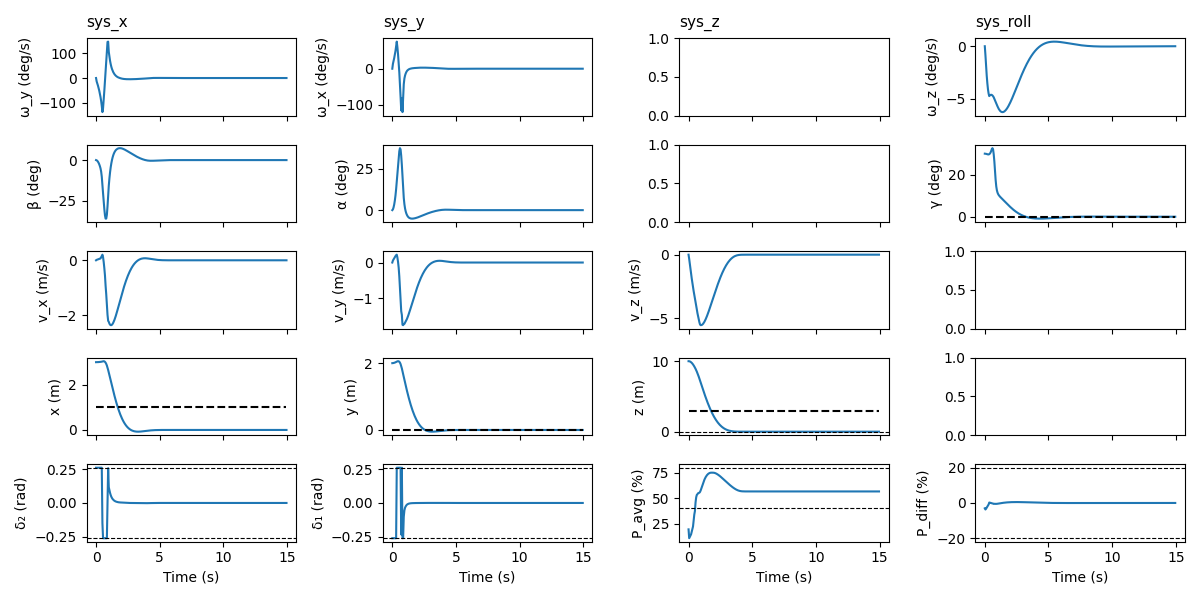

In [9]:
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

## Analysis

**Questions to answer:**
1. Does the NMPC successfully land the rocket at the target (1, 0, 3) with 0° roll?
2. How does NMPC performance compare with the linear MPC from Part 6?
3. Are all constraints satisfied (z ≥ 0, |β| ≤ 80°, input bounds)?
4. What are the advantages of NMPC over linear MPC for this task?
5. What is the computational cost (solve time per iteration)?

In [10]:
# Compare final state with target
print("\nLanding Performance:")
print(f"  Target position: ({xs[9]:.2f}, {xs[10]:.2f}, {xs[11]:.2f})")
print(f"  Final position:  ({x_cl[9, -1]:.2f}, {x_cl[10, -1]:.2f}, {x_cl[11, -1]:.2f})")
print(f"  Position error:  ({abs(x_cl[9, -1] - xs[9]):.3f}, {abs(x_cl[10, -1] - xs[10]):.3f}, {abs(x_cl[11, -1] - xs[11]):.3f})")
print(f"\n  Target roll: {np.rad2deg(xs[5]):.2f}°")
print(f"  Final roll:  {np.rad2deg(x_cl[5, -1]):.2f}°")
print(f"  Roll error:  {np.rad2deg(abs(x_cl[5, -1] - xs[5])):.3f}°")


Landing Performance:
  Target position: (1.00, 0.00, 3.00)
  Final position:  (-0.00, -0.00, 0.00)
  Position error:  (1.000, 0.000, 3.000)

  Target roll: 0.00°
  Final roll:  -0.00°
  Roll error:  0.000°
